## Question 1 Part 1


In [1]:
#######OMML Assignment ####################
import numpy as np
import OMML_gen_data as data
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

def toVector(v, w, b):
    assert v.shape == (v.shape[0], v.shape[1])
    assert w.shape == (w.shape[0], w.shape[1])
    assert b.shape == (b.shape[0], b.shape[1])
    return np.hstack([v.flatten(), w.flatten(),b.flatten()])

def toWZ(vec,shapes):
    
    vshape,wshape,bshape = shapes
    v1 = vec[:vshape[0]*vshape[1]].reshape(vshape[0],vshape[1])
    v2 = vec[vshape[0]*vshape[1]:vshape[0]*vshape[1]+wshape[0]*wshape[1]].reshape(wshape[0],wshape[1])
    v3 = vec[-bshape[0]*bshape[1]:].reshape(bshape[0],bshape[1])
    return v1,v2,v3

def g(t,sigma):
    val = (1-np.exp(-sigma*t))/(1+np.exp(-sigma*t))
    return val


def fx(X,v,w,b,sig):
    
    #dimensions of X  = p x n
    
    #(v,w,b) = params
    #v                  #vector of length equal to no of neurons N x 1
    #w                  #matrix of dimension N x n
    #b                  # N x 1
    
    #np.tanh(np.dot(w,X.T) - b)                        # N x p 
    
    
    f_xp = np.dot(v.T,g((np.dot(w,X.T) - b),sig))           #1xN x Nxp = 1xp vector
    return f_xp.T


def cost_function(vctr,X,y,roh,shapes,sigma):
    
#     No_nueron_units = 3
#     v = np.empty([No_nueron_units,1])                 #vector of length equal to no of neurons N x 1
#     w = np.empty([No_nueron_units,X.shape[1]])        #matrix of dimension N x n
#     b = np.empty([No_nueron_units,1])                 # N x 1
#     params = [v,w,b]
    
    v,w,b = toWZ(vctr,shapes)
    
    reg_term = roh*np.sqrt(np.sum(abs(w)**2) + np.sum(abs(b)**2) + np.sum(abs(v)**2))
    cost = np.sum((fx(X,v,w,b,sigma).reshape(X.shape[0],1) - y.reshape(len(y),1))**2)/(2*len(y)) + reg_term
    
    return cost




def select_parameters_mlp(dct_object):
    # Find parameters having lowest test and train error.
    tst_error_list = []
    train_error_list = []
    for i in dct_object:
        tst_error_list.append(dct_object[i]['test_error'])
        train_error_list.append(dct_object[i]['train_error'])

    a,b = tst_error_list.index(min(tst_error_list)),train_error_list.index(min(train_error_list))
    return dct_object[a+1]




def init_parameters(Num_nuerons = 10, X = data.X_train):

    No_nueron_units = Num_nuerons
    np.random.seed(1772576)
    v = np.random.rand(No_nueron_units,1)                 #vector of length equal to no of neurons N x 1
    w = np.random.rand(No_nueron_units,X.shape[1])        #matrix of dimension N x n
    b = np.random.rand(No_nueron_units,1)                 # N x 1
    shapes = (v.shape,w.shape,b.shape)
    vctr = toVector(v,w,b)
    
    return(vctr,shapes)
    


def gridsearch(X_train,y_train,X_test,y_test,N_vec=[4,10,20],roh_vec=[0.0001,0.01,0.05,0.1,3,0.0003],sigma_vec = [0.001,0.1,0.05]):
    X = X_train
    yy = y_train.reshape(len(y_train),1)

    dumpdct={}
    cnt = 0
    for N in N_vec:
        vctr,shapes = init_parameters(N,X)
        for roh in roh_vec:
            for sigma in sigma_vec:
                cnt = cnt+1
                res = minimize(cost_function, vctr,args=(X,yy,roh,shapes,sigma),method='BFGS',options={'disp': True,'maxiter':30000})
                v_hat,w_hat,b_hat = toWZ(res.x,shapes)
                #res.fun                                        #train error
                err = cost_function(res.x,X_test,y_test,roh,shapes,sigma)    #test error
                dumpdct[cnt] = {'N':N,'roh':roh,'sigma':sigma,'train_error':res.fun,'test_error':err}

                
                
    #select parameters with lowest test and train errors
    param_dct = select_parameters_mlp(dumpdct)
    
    #test set predictions on these parameters
    vctr,shapes = init_parameters(param_dct['N'],X_train)

    res_test = minimize(cost_function, vctr,args=(X,yy,param_dct['roh'],shapes,param_dct['sigma']),method='Nelder-Mead',options={'disp': True,'maxiter':30000})
    v_hat,w_hat,b_hat = toWZ(res_test.x,shapes)
    y_hat = fx(X_test,v_hat,w_hat,b_hat,param_dct['sigma'])
    
    return y_hat,v_hat,w_hat,b_hat,param_dct
    

In [2]:
X_train = data.X_train
X_test = data.X_test
y_train = data.y_train
y_test = data.y_test

In [49]:
import time

start = time.time()
y_hat,v_hat,w_hat,b_hat,dct_mlp = gridsearch(X_train,y_train,X_test,y_test)
end = time.time()
print(end - start)

Optimization terminated successfully.
         Current function value: 0.021813
         Iterations: 118
         Function evaluations: 2466
         Gradient evaluations: 137
Optimization terminated successfully.
         Current function value: 0.010654
         Iterations: 744
         Function evaluations: 14868
         Gradient evaluations: 826
Optimization terminated successfully.
         Current function value: 0.015659
         Iterations: 145
         Function evaluations: 3078
         Gradient evaluations: 171
         Current function value: 0.142896
         Iterations: 48
         Function evaluations: 2982
         Gradient evaluations: 165
Optimization terminated successfully.
         Current function value: 0.081198
         Iterations: 66
         Function evaluations: 1296
         Gradient evaluations: 72
Optimization terminated successfully.
         Current function value: 0.104442
         Iterations: 62
         Function evaluations: 1188
         Gradient ev

In [24]:
# import pandas as pd
# pd.DataFrame(X_train).to_csv('X_train.csv',index = False)
# pd.DataFrame(y_train).to_csv('y_train.csv',index = False)
# pd.DataFrame(X_test).to_csv('X_test.csv',index = False)
# pd.DataFrame(y_test).to_csv('y_test.csv',index = False)


In [7]:
##### Uncomment to view to predictions #########################

#pd.DataFrame({'x':y_hat.reshape(len(y_hat)),'y':y_test})
#pd.reset_option('^display.', silent=True)
#pd.set_option('display.float_format', lambda x: '%.5f' % x)


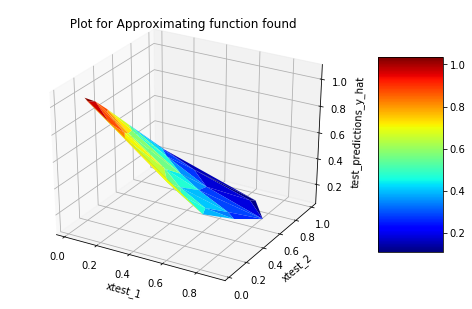

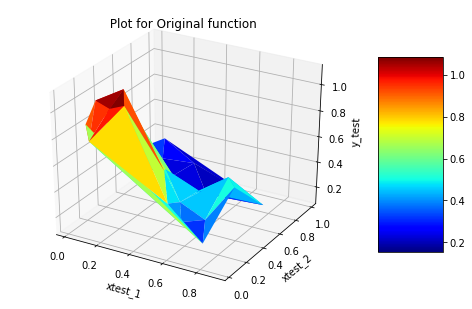

In [50]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_hat.flatten(), cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=10, aspect=3)

ax.set_xlabel('xtest_1')
ax.set_ylabel('xtest_2')
ax.set_zlabel('test_predictions_y_hat')
plt.title(' Plot for Approximating function found ')
plt.show()


fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_test.flatten(), cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=10, aspect=3)

ax.set_xlabel('xtest_1')
ax.set_ylabel('xtest_2')
ax.set_zlabel('y_test')
plt.title(' Plot for Original function ')
plt.show()



## Question1 Part 2

In [51]:
def toVector_rbf(v, c):
    assert v.shape == (v.shape[0], v.shape[1])
    assert c.shape == (c.shape[0], c.shape[1])
    return np.hstack([v.flatten(), c.flatten()])

def toWZ_rbf(vec,shapes):
    
    vshape,cshape = shapes
    v1 = vec[:vshape[0]*vshape[1]].reshape(vshape[0],vshape[1])
    v2 = vec[-cshape[0]*cshape[1]:].reshape(cshape[0],cshape[1])
    return v1,v2

def gauss(t,ci,sigma):
    
    #c=c.reshape(len(c),1)
    k = np.sqrt(np.sum((abs(t-ci)**2),axis = 1))
    val = np.exp(-((k/sigma)**2))
    
    return val


def fx_rbf(X,v,c,sigma):
    
    #dimensions of X  = p x n
    #v  vector of length equal to no of neurons N x 1
    #c  vector of length equal to no of neurons N x 1
    if v.shape[0]!=c.shape[0]:
        raise(Exception('v,c, should have same length !'))
    
    v = v.reshape(len(v),1)
    gauss_mat = np.empty([X.shape[0],v.shape[0]])
    
    for i in range(c.shape[0]):
        gauss_mat[:,i] = gauss(X,c[i],sigma)
        
    
    
    out = np.dot(gauss_mat,v)   #pxN x Nx1 = px1 vector
                                                    
    return out


def cost_function_rbf(vctr,X,y,roh,shapes,sigma):
    
#     No_nueron_units = 3
#     v = np.empty([No_nueron_units,1])                 #vector of length equal to no of neurons N x 1
#     w = np.empty([No_nueron_units,X.shape[1]])        #matrix of dimension N x n
#     b = np.empty([No_nueron_units,1])                 # N x 1
#     params = [v,w,b]
    
    v,c = toWZ_rbf(vctr,shapes)
    
    reg_term = roh*np.sqrt(np.sum(abs(v)**2) + np.sum(abs(c)**2))
    cost = np.sum((fx_rbf(X,v,c,sigma).reshape(X.shape[0],1) - y.reshape(len(y),1))**2)/(2*len(y)) + reg_term
    
    return cost




def init_parameters_rbf(Num_nuerons = 10, X = data.X_train):

    No_nueron_units = Num_nuerons
    np.random.seed(1772576)
    v = np.random.rand(No_nueron_units,1)                 #vector of length equal to no of neurons N x 1
    c = np.random.rand(No_nueron_units,X.shape[1])        # N x n 
    shapes = (v.shape,c.shape)
    vctr = toVector_rbf(v,c)
    
    return(vctr,shapes)
    

def select_parameters_rbf(dct_object):
    # Find parameters having lowest test and train error.
    tst_error_list = []
    train_error_list = []
    for i in dct_object:
        tst_error_list.append(dct_object[i]['test_error'])
        train_error_list.append(dct_object[i]['train_error'])

    a,b = tst_error_list.index(min(tst_error_list)),train_error_list.index(min(train_error_list))
    return dct_object[a+1]



def gridsearch_rbf(X_train,y_train,X_test,y_test,N_vec=[4,10,20],roh_vec=[0.0001,0.01,0.05,0.1,3,0.0003],sigma_vec = [0.001,0.1,0.05]):
    X = X_train
    yy = y_train.reshape(len(y_train),1)

    dumpdct={}
    cnt = 0
    for N in N_vec:
        vctr,shapes = init_parameters_rbf(N,X)
        for roh in roh_vec:
            for sigma in sigma_vec:
                cnt = cnt+1
                res = minimize(cost_function_rbf, vctr,args=(X,yy,roh,shapes,sigma),method='Nelder-Mead',options={'disp': True,'maxiter':30000})
                v_hat,c_hat = toWZ_rbf(res.x,shapes)
                #res.fun                                        #train error
                err = cost_function_rbf(res.x,X_test,y_test,roh,shapes,sigma)    #test error
                dumpdct[cnt] = {'N':N,'roh':roh,'sigma':sigma,'train_error':res.fun,'test_error':err}
            
    #select parameters with lowest test and train errors
    param_dct = select_parameters_rbf(dumpdct)
    
    #test set predictions on these parameters
    vctr,shapes = init_parameters_rbf(param_dct['N'],X_train)

    res_test = minimize(cost_function_rbf, vctr,args=(X,yy,param_dct['roh'],shapes,param_dct['sigma']),method='Nelder-Mead',options={'disp': True,'maxiter':30000})
    v_hatrbf,c_hatrbf = toWZ_rbf(res_test.x,shapes)
    y_hat_rbf = fx_rbf(X_test,v_hatrbf,c_hatrbf,param_dct['sigma'])
    
    return y_hat_rbf,v_hatrbf,c_hatrbf,param_dct


In [ ]:
kkk = np.random.rand(10,X_train.shape[1])
vvv = np.random.rand(10,1)
sh = (vvv.shape,kkk.shape)
#toVector_rbf(vvv,kkk).shape
#toWZ_rbf(toVector_rbf(vvv,kkk),sh)[1]
#X_train - kkk[1]
#np.exp(-(np.sqrt(np.sum((X_train - kkk[0])**2,axis = 1 )) / 100)**2),gauss(X_train,kkk[0],100)
gauss(X_train,kkk[0],100).shape
#np.sqrt(np.sum((abs(t-ci)**2),axis = 1))

In [52]:
import time

start_rbf = time.time()
y_hat_rbf,v_hatrbf,c_hatrbf,dct_rbf = gridsearch_rbf(X_train,y_train,X_test,y_test)
end_rbf = time.time()
print(end_rbf - start_rbf)




Optimization terminated successfully.
         Current function value: 0.130339
         Iterations: 2797
         Function evaluations: 3881
Optimization terminated successfully.
         Current function value: 0.043789
         Iterations: 3437
         Function evaluations: 4705
Optimization terminated successfully.
         Current function value: 0.094561
         Iterations: 4044
         Function evaluations: 5513
Optimization terminated successfully.
         Current function value: 0.144889
         Iterations: 334
         Function evaluations: 573
Optimization terminated successfully.
         Current function value: 0.056726
         Iterations: 2212
         Function evaluations: 3021
Optimization terminated successfully.
         Current function value: 0.126731
         Iterations: 3766
         Function evaluations: 5082
Optimization terminated successfully.
         Current function value: 0.195347
         Iterations: 616
         Function evaluations: 956
Optimizati

In [52]:
##### Uncomment to view to predictions #########################

#pd.DataFrame({'x':y_hat_rbf.reshape(30),'y':y_test})
#pd.reset_option('^display.', silent=True)
#pd.set_option('display.float_format', lambda x: '%.5f' % x)
#dct_rbf

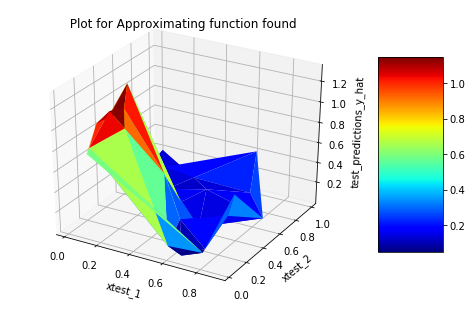

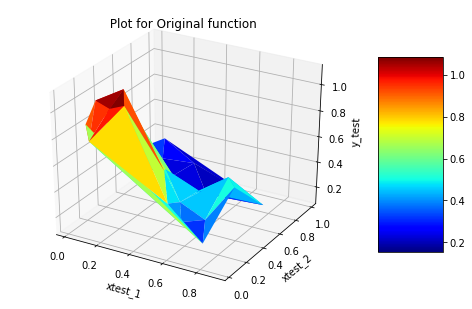

In [53]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_hat_rbf.flatten(),cmap=cm.jet,  linewidth=0.1)
fig.colorbar(surf, shrink=10, aspect=3)

ax.set_xlabel('xtest_1')
ax.set_ylabel('xtest_2')
ax.set_zlabel('test_predictions_y_hat')
plt.title(' Plot for Approximating function found ')
plt.show()


fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_test.flatten(),cmap=cm.jet,  linewidth=0.1)
fig.colorbar(surf, shrink=10, aspect=3)

ax.set_xlabel('xtest_1')
ax.set_ylabel('xtest_2')
ax.set_zlabel('y_test')
plt.title(' Plot for Original function ')
plt.show()



## Question 2 part1


In [54]:

def init_parameters_mlp2(Num_nuerons = 10, X = data.X_train):

    No_nueron_units = Num_nuerons
    #np.random.seed(1772576)
    v = np.random.rand(No_nueron_units,1)                 #vector of length equal to no of neurons N x 1
    w = np.random.rand(No_nueron_units,X.shape[1])        #matrix of dimension N x n
    b = np.random.rand(No_nueron_units,1)                 # N x 1
    #shapes = (v.shape,w.shape,b.shape)
    #vctr = toVector(v,w,b)
    
    return(v,w,b)



def optimize_mlp(X_train,y_train,X_test,y_test,param_dct):
    X = X_train
    yy = y_train.reshape(len(y_train),1)
            
    #param_dct is the dictionary of parameters of RBF network in Q1 Part 2  
    
    
    #test set predictions on these parameters
    v,w_hatmlp,b_hatmlp = init_parameters_mlp2(param_dct['N'],X_train)
    res = minimize(cost_function_mlp, v,args=(w_hatmlp,b_hatmlp,X_train,y_train,param_dct['roh'],param_dct['sigma']),method='Nelder-Mead',options={'disp': True,'maxiter':30000})
    v_hatmlp = res.x
    y_hat_mlp = fx(X_test,v_hatmlp,w_hatmlp,b_hatmlp,param_dct['sigma'])
    test_se = cost_function_mlp(v_hatmlp,w_hatmlp,b_hatmlp,X_test,y_test,param_dct['roh'],param_dct['sigma'])
    
    return y_hat_mlp,v_hatmlp,w_hatmlp,b_hatmlp,param_dct,test_se


def gridsearch_mlp(X_train,y_train,X_test,y_test,N_vec=[4,10,20],roh_vec=[0.0001,0.01,0.05,0.1,3,0.0003],sigma_vec = [0.001,0.1,0.05]):
    X = X_train
    yy = y_train.reshape(len(y_train),1)

    dumpdct={}
    cnt = 0
    for N in N_vec:
        v,w_hatmlp,b_hatmlp = init_parameters_mlp2(N,X)
        for roh in roh_vec:
            for sigma in sigma_vec:
                cnt = cnt+1
                res = minimize(cost_function_mlp, v,args=(w_hatmlp,b_hatmlp,X_train,y_train,roh,sigma),method='Nelder-Mead',options={'disp': True,'maxiter':30000})
                v_hatmlp = res.x
                #res.fun                                                                   #train error
                err = cost_function_mlp(v_hatmlp,w_hatmlp,b_hatmlp,X_test,y_test,roh,sigma)    #test error
                dumpdct[cnt] = {'N':N,'roh':roh,'sigma':sigma,'train_error':res.fun,'test_error':err}

                
                
    #select parameters with lowest test and train errors
    param_dct = select_parameters_mlp(dumpdct)
    
    #test set predictions on these parameters
    v,w_hatmlp,b_hatmlp = init_parameters_mlp2(param_dct['N'],X_train)

    res = minimize(cost_function_mlp, v,args=(w_hatmlp,b_hatmlp,X_train,y_train,param_dct['roh'],param_dct['sigma']),method='Nelder-Mead',options={'disp': True,'maxiter':30000})
    v_hatmlp = res.x
    y_hat_mlp = fx(X_test,v_hatmlp,w_hatmlp,b_hatmlp,param_dct['sigma'])   #predictions on test set
    test_se = cost_function_mlp(v_hatmlp,w_hatmlp,b_hatmlp,X_test,y_test,param_dct['roh'],param_dct['sigma'])
    
    return y_hat_mlp,v_hatmlp,w_hatmlp,b_hatmlp,param_dct,test_se


def cost_function_mlp(v,w,b,X,y,roh,sigma):
    
#     No_nueron_units = 3
#     v = np.empty([No_nueron_units,1])                 #vector of length equal to no of neurons N x 1
#     w = np.empty([No_nueron_units,X.shape[1]])        #matrix of dimension N x n
#     b = np.empty([No_nueron_units,1])                 # N x 1
#     params = [v,w,b]
    

    
    reg_term = roh*np.sqrt(np.sum(abs(w)**2) + np.sum(abs(b)**2) + np.sum(abs(v)**2))
    cost = np.sum((fx(X,v,w,b,sigma).reshape(X.shape[0],1) - y.reshape(len(y),1))**2)/(2*len(y)) + reg_term
    
    return cost




In [55]:
import time

start_mlp = time.time()
y_hat_mlp, v_hatmlp, w_hatmlp, b_hatmlp, dct_mlp2,test_error_mlp = gridsearch_mlp(X_train,y_train,X_test,y_test)
end_mlp = time.time()
print(end_mlp-start_mlp)

Optimization terminated successfully.
         Current function value: 0.142606
         Iterations: 213
         Function evaluations: 365
Optimization terminated successfully.
         Current function value: 0.018682
         Iterations: 358
         Function evaluations: 612
Optimization terminated successfully.
         Current function value: 0.022632
         Iterations: 346
         Function evaluations: 595
Optimization terminated successfully.
         Current function value: 0.163522
         Iterations: 130
         Function evaluations: 219
Optimization terminated successfully.
         Current function value: 0.152891
         Iterations: 166
         Function evaluations: 284
Optimization terminated successfully.
         Current function value: 0.160468
         Iterations: 208
         Function evaluations: 352
Optimization terminated successfully.
         Current function value: 0.246032
         Iterations: 127
         Function evaluations: 214
Optimization termina

In [27]:
##### Uncomment to view to predictions #########################

#pd.DataFrame({'x':y_hat_mlp.reshape(30),'y':y_test})
#pd.reset_option('^display.', silent=True)
#pd.set_option('display.float_format', lambda x: '%.5f' % x)
#dct_mlp2

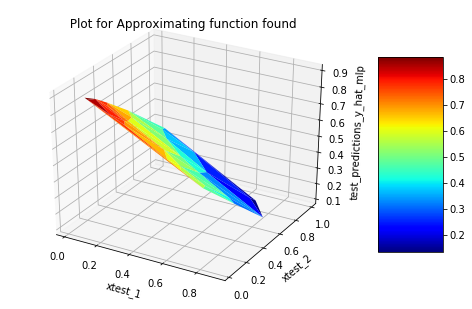

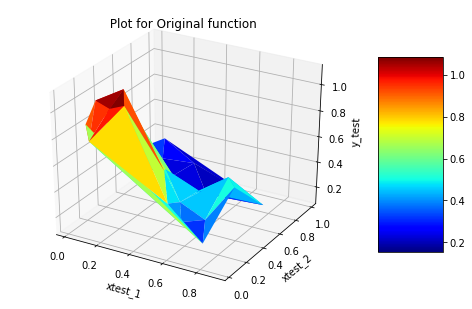

In [56]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_hat_mlp.flatten(),cmap=cm.jet,  linewidth=0.1)
fig.colorbar(surf, shrink=10, aspect=3)

ax.set_xlabel('xtest_1')
ax.set_ylabel('xtest_2')
ax.set_zlabel('test_predictions_y_hat_mlp')
plt.title(' Plot for Approximating function found ')
plt.show()


fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_test.flatten(),cmap=cm.jet,  linewidth=0.1)
fig.colorbar(surf, shrink=10, aspect=3)

ax.set_xlabel('xtest_1')
ax.set_ylabel('xtest_2')
ax.set_zlabel('y_test')
plt.title(' Plot for Original function ')
plt.show()



## Question2 part2

In [57]:
# Estimate centroids for RBF network by K-Means
from sklearn.cluster import KMeans


In [39]:
#%timeit gauss(X_train,cluster_centroids[0,:],0.1)
#%timeit fx_rbf(X_train,np.random.rand(10,1),cluster_centroids,0.1)

In [58]:

def init_parameters_rbf_2(Num_nuerons = 10, X = data.X_train):

    No_nueron_units = Num_nuerons
    np.random.seed(1772576)
    
    
    # estimate cluster centroids by K Means
    est = KMeans(n_clusters=No_nueron_units)
    est_obj = est.fit(X)
    cluster_centroids = est_obj.cluster_centers_
    
    v = np.random.rand(No_nueron_units,1)                 #vector of length equal to no of neurons N x 1

    #shapes = (v.shape,cluster_centroids.shape)
    #vctr = toVector_rbf(v,cluster_centroids)
    
    return(v,cluster_centroids)



def optimize(X_train,y_train,X_test,y_test,param_dct):
    X = X_train
    yy = y_train.reshape(len(y_train),1)
            
    #param_dct is the dictionary of parameters of RBF network in Q1 Part 2  
    
    
    #test set predictions on these parameters
    v,c_hatrbf = init_parameters_rbf_2(param_dct['N'],X_train)
    res = minimize(cost_function_rbf_2, v,args=(c_hatrbf,X_train,y_train,param_dct['roh'],param_dct['sigma']),method='Nelder-Mead',options={'disp': True,'maxiter':30000})
    v_hatrbf = res.x
    y_hat_rbf = fx_rbf(X_test,v_hatrbf,c_hatrbf,param_dct['sigma'])
    test_se = cost_function_rbf_2(v_hatrbf,c_hatrbf,X_test,y_test,param_dct['roh'],param_dct['sigma'])
    
    return y_hat_rbf,v_hatrbf,c_hatrbf,param_dct,test_se


def cost_function_rbf_2(v,c,X,y,roh,sigma):
    
#     v = np.empty([No_nueron_units,1])                 #vector of length equal to no of neurons N x 1
#     w = np.empty([No_nueron_units,X.shape[1]])        #matrix of dimension N x n
#     b = np.empty([No_nueron_units,1])                 # N x 1

    
    reg_term = roh*np.sqrt(np.sum(abs(v)**2) + np.sum(abs(c)**2))
    cost = np.sum((fx_rbf(X,v,c,sigma).reshape(X.shape[0],1) - y.reshape(len(y),1))**2)/(2*len(y)) + reg_term
    
    return cost



In [59]:
import time

start_rbf2 = time.time()
y_hatrbf_2,v_hatrbf_2,c_hatrbf_2,dct_rbf_2,test_error_2 = optimize(X_train,y_train,X_test,y_test,dct_rbf)
end_rbf2 = time.time()
print(end_rbf2-start_rbf2)

Optimization terminated successfully.
         Current function value: 0.014498
         Iterations: 10568
         Function evaluations: 13299
5.5210394859313965


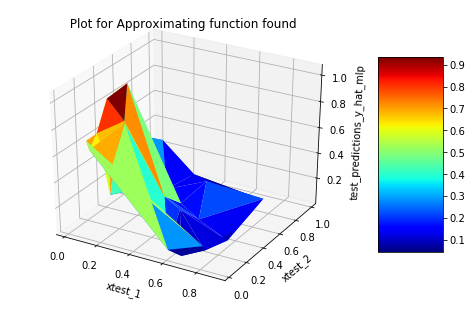

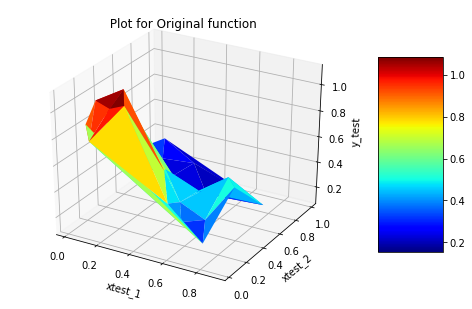

In [60]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_hatrbf_2.flatten(),cmap=cm.jet,  linewidth=0.1)
fig.colorbar(surf, shrink=10, aspect=3)

ax.set_xlabel('xtest_1')
ax.set_ylabel('xtest_2')
ax.set_zlabel('test_predictions_y_hat_mlp')
plt.title(' Plot for Approximating function found ')
plt.show()


fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_test.flatten(),cmap=cm.jet,  linewidth=0.1)
fig.colorbar(surf, shrink=10, aspect=3)

ax.set_xlabel('xtest_1')
ax.set_ylabel('xtest_2')
ax.set_zlabel('y_test')
plt.title(' Plot for Original function ')
plt.show()



## Question 3 

In [61]:
### Two Block Decomposition Method ####



# def gauss_3(t,ci,sigma):
    
#     #c=c.reshape(len(c),1)
#     k = np.sqrt(np.sum((abs(t-ci)**2),axis = 1))
#     k2 = np.sum(abs(t - ci),axis = 1)
#     val = np.exp(-((k/sigma)**2))
    
#     return val,k2

def gauss_3(t,ci,sigma):
    
    #c=c.reshape(len(c),1)
    k = np.sqrt(np.sum((abs(t-ci)**2),axis = 1))
    k2 = abs(t - ci)
    val = np.exp(-((k/sigma)**2))
    
    return val,k2

    

def fx_rbf_3(X,v,c,sigma):
    
    #dimensions of X  = p x n
    #v  vector of length equal to no of neurons N x 1
    #c  vector of length equal to no of neurons N x 1
    c = c.reshape(v.shape[0],X.shape[1])
    if v.shape[0]!=c.shape[0]:
        raise(Exception('v,c, should have same length !'))
    
    v = v.reshape(len(v),1)
    gauss_mat = np.empty([X.shape[0],v.shape[0]])
    l1_norm_mat = []
    
    for i in range(c.shape[0]):
        g1,g2 = gauss_3(X,c[i],sigma)
        gauss_mat[:,i] = g1
        l1_norm_mat.append(g2)
    
    
    out = np.dot(gauss_mat,v)   #pxN x Nx1 = px1 vector
                            
    return out,gauss_mat,l1_norm_mat


def cost_function_rbf(v,c,X,y,roh,sigma):
    
#     No_nueron_units = 3
#     v = np.empty([No_nueron_units,1])                 #vector of length equal to no of neurons N x 1
#     w = np.empty([No_nueron_units,X.shape[1]])        #matrix of dimension N x n
#     b = np.empty([No_nueron_units,1])                 # N x 1
#     params = [v,w,b]
    
    #v,c = toWZ_rbf(vctr,shapes)
    
    
    reg_term = roh*np.sqrt(np.sum(abs(v)**2) + np.sum(abs(c)**2))
    cost = np.sum((fx_rbf_3(X,v,c,sigma)[0].reshape(X.shape[0],1) - y.reshape(len(y),1))**2)/(2*len(y)) + reg_term


    #gradients = np.hstack([grad_v(X,v,c,sigma,y).flatten(),grad_c(X,v,c,sigma,y).flatten()])
    return cost

def cost_function_rbf_c(c,v,X,y,roh,sigma):
    
#     No_nueron_units = 3
#     v = np.empty([No_nueron_units,1])                 #vector of length equal to no of neurons N x 1
#     w = np.empty([No_nueron_units,X.shape[1]])        #matrix of dimension N x n
#     b = np.empty([No_nueron_units,1])                 # N x 1
#     params = [v,w,b]
    
    #v,c = toWZ_rbf(vctr,shapes)
    
    
    reg_term = roh*np.sqrt(np.sum(abs(v)**2) + np.sum(abs(c)**2))
    cost = np.sum((fx_rbf_3(X,v,c,sigma)[0].reshape(X.shape[0],1) - y.reshape(len(y),1))**2)/(2*len(y)) + reg_term


    #gradients = np.hstack([grad_v(X,v,c,sigma,y).flatten(),grad_c(X,v,c,sigma,y).flatten()])
    return cost



def grad_v(v,c,X,y,roh,sigma):
    
    val,gauss_matrix,dump = fx_rbf_3(X,v,c,sigma)
    values = []
    values = [np.dot(((val.reshape(X.shape[0],1) - y.reshape(len(y),1)).T),gauss_matrix[:,i].reshape(X.shape[0],1)) + (abs(2*v[i])*roh) for i in range(v.shape[0])]
    val1 = (np.array(values) / X.shape[0]) 
    return val1.reshape(val1.shape[0])   #vector of gradients for dE/dv1 , dE/dv2 .....

def grad_c(c,v,X,y,roh,sigma):
    
    c = c.reshape(v.shape[0],X.shape[1])
    val,gauss_matrix,l1_mat = fx_rbf_3(X,v,c,sigma)
    vect = [np.dot((val.reshape(X.shape[0],1) - y.reshape(len(y),1)).T ,(gauss_matrix[:,i] * v[i] * l1_mat[i][0:,0].reshape(X.shape[0]))) + (abs(2*c[i][0])*roh) for i in range(c.shape[0])]
    vect1 = [np.dot((val.reshape(X.shape[0],1) - y.reshape(len(y),1)).T ,(gauss_matrix[:,i] * v[i] * l1_mat[i][0:,1].reshape(X.shape[0]))) + (abs(2*c[i][1])*roh) for i in range(c.shape[0])] 
    value = np.hstack([vect,vect1]).reshape(len(vect)*2,1)
    value = (2*value)/(X.shape[0]*(sigma**2))
    
    return value.reshape(value.shape[0])  #vector of gradients for dE/dc1 , dE/dc2 .....
    

def two_block(v,c,X,y,roh,sigma):
    
    tol = [1e-6,1e-3]
    #J = nd.Jacobian(cost_function_rbf_c)
    #J(cc.flatten(),vv,X_train,y_train,3,1)
    lst = []
    while(True):
        ### optimize v ####
        res_v = minimize(cost_function_rbf, v,args=(c,X,y,roh,sigma)
                 ,method='CG',jac=grad_v,options={'disp': True,'maxiter':30000})
        v_hat = res_v.x
        norm = np.linalg.norm(J(c.flatten(),v_hat,X,y,roh,sigma), ord=2)    # l2norm of gradient dE/dc evaluated at v_hat 
        if (norm >= tol[0] and norm <= tol[1]):
            break
        
        ### optimize c ###
        #return(v_hat)
        res_c = minimize(cost_function_rbf_c, c.flatten(),args=(v_hat,X,y,roh,sigma)
                 ,method='CG',options={'disp': True,'maxiter':30000})
        ### update parameters #####
        lst.append(cost_function_rbf(v_hat,c,X,y,roh,sigma))
        v = v_hat
        c = res_c.x
    print('out of the loop')
    return v_hat,c


In [62]:
v_hat_bl,c_hat_bl = two_block(vv,cc,X_train,y_train,0.0003,0.1)

         Current function value: 0.068041
         Iterations: 6
         Function evaluations: 114
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.066192
         Iterations: 36
         Function evaluations: 744
         Gradient evaluations: 62
         Current function value: 0.064343
         Iterations: 3
         Function evaluations: 100
         Gradient evaluations: 88
Optimization terminated successfully.
         Current function value: 0.063159
         Iterations: 26
         Function evaluations: 612
         Gradient evaluations: 51
         Current function value: 0.062365
         Iterations: 2
         Function evaluations: 53
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.062003
         Iterations: 50
         Function evaluations: 1128
         Gradient evaluations: 94
         Current function value: 0.061833
         Iterations: 4
         Func

In [64]:
y_hat_bl = fx_rbf_3(X_test,v_hat_bl,c_hat_bl,0.1)[0] 
cost_function_rbf(v_hat_bl,c_hat_bl,X_test,y_test,0.0003,0.1)
#pd.DataFrame({'x':y_hat_bl.reshape(30),'y':y_test})

0.076181777595164979

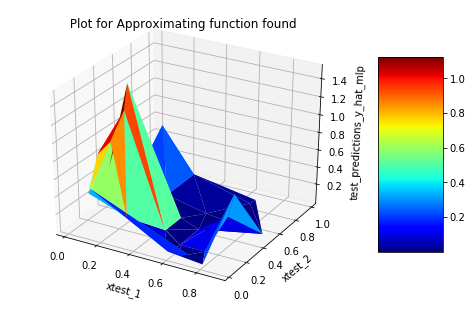

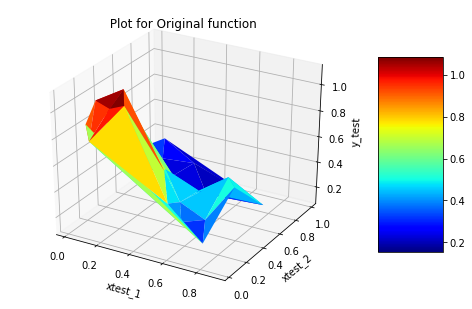

In [65]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_hat_bl.flatten(),cmap=cm.jet,  linewidth=0.1)
fig.colorbar(surf, shrink=10, aspect=3)

ax.set_xlabel('xtest_1')
ax.set_ylabel('xtest_2')
ax.set_zlabel('test_predictions_y_hat_mlp')
plt.title(' Plot for Approximating function found ')
plt.show()


fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_test.flatten(),cmap=cm.jet,  linewidth=0.1)
fig.colorbar(surf, shrink=10, aspect=3)

ax.set_xlabel('xtest_1')
ax.set_ylabel('xtest_2')
ax.set_zlabel('y_test')
plt.title(' Plot for Original function ')
plt.show()



In [12]:
tol = [1e-6,1e-3]
res_v = minimize(cost_function_rbf, vv,args=(cc,X_train,y_train,0.0003,0.1)
                 ,method='CG',jac=grad_v,options={'disp': True,'maxiter':30000})
v_hat = res_v.x
norm = np.linalg.norm(grad_c(cc,v_hat,X_train,y_train,0.0003,0.1), ord=2)    # l2norm of gradient dE/dc evaluated at v_hat 
if (norm >= tol[0] and norm <= tol[1]):
    print(norm)
        
        ### optimize c ###
        #return(v_hat)
res_c = minimize(cost_function_rbf_c, cc.flatten(),args=(v_hat,X_train,y_train,0.0003,0.1)
                 ,method='CG',options={'disp': True,'maxiter':30000})


         Current function value: 0.075373
         Iterations: 7
         Function evaluations: 119
         Gradient evaluations: 107
Optimization terminated successfully.
         Current function value: 0.068807
         Iterations: 43
         Function evaluations: 960
         Gradient evaluations: 80


In [13]:
norm

0.0030267405110373817

In [17]:
import numdifftools as nd 
J = nd.Jacobian(cost_function_rbf_c)
J(cc.flatten(),vv,X_train,y_train,3,1)


array([[ 0.87982634,  0.55613478,  0.57364795,  0.65046288,  0.73026862,
         0.71906101,  0.76224343,  0.76960987,  0.66764188,  0.70951008]])

In [19]:
#cost_function_rbf_c(cc,vv,X_train,y_train,0.0003,0.1),cost_function_rbf(vv,cc,X_train,y_train,0.0003,0.1)

grad_c(cc.flatten(),vv,X_train,y_train,3,1)
#grad_v(vv,cc.flatten(),X_train,y_train,0.0003,0.1)

array([ 0.40397195,  0.31523316,  0.43978079,  0.43585068,  0.68184145,
        0.56952836,  0.59223408,  0.48157126,  0.58893893,  0.52727802])

In [12]:
vv,cc = init_parameters_rbf_2(5,X_train)
vec, mat, an = fx_rbf_3(X_train,vv,cc,0.2)
toVector_rbf(vv,cc)
#grad_c(vv,cc,X_train,y_train,0.1,0.2)
cost_function_rbf(vv,cc,X_train,y_train,0.1,0.2)
cc

array([[ 0.82568137,  0.24350796],
       [ 0.1703464 ,  0.23497398],
       [ 0.43385534,  0.57727314],
       [ 0.86213657,  0.80966664],
       [ 0.09165737,  0.7963087 ]])

In [49]:
grad_v(vv,cc,X_train,y_train,10,0.2)
#grad_c(cc,vv,X_train,y_train,10,0.0002)



array([ 0.09285652,  0.15370148,  0.14039151,  0.20761209,  0.2089991 ])

In [68]:
vt = [np.dot((vec.reshape(X_train.shape[0],1) - y_train.reshape(len(y_train),1)).T ,(mat[:,i] * vv[i] * an[i][0:,0].reshape(X_train.shape[0]))) + (abs(2*cc[i][0])*0.1) for i in range(cc.shape[0])]


In [73]:
np.hstack([vt,vt]).reshape(len(vt)*2,1)

array([[ 0.01023357],
       [ 0.01023357],
       [ 0.1573619 ],
       [ 0.1573619 ],
       [-0.3145868 ],
       [-0.3145868 ],
       [ 0.2786662 ],
       [ 0.2786662 ],
       [ 0.12589968],
       [ 0.12589968]])

In [556]:
xxx = minimize(cost_function_rbf_c, cc.flatten(),args=(vv,X_train,y_train,1,2),method='CG',jac=grad_c,options={'disp': True,'maxiter':30000})

         Current function value: 11.613776
         Iterations: 0
         Function evaluations: 97
         Gradient evaluations: 85


In [557]:
xxx.jac

array([ 0.00509757,  0.00192025,  0.00055053,  0.00188946,  0.00553771,
        0.00489471,  0.00307858,  0.00290329,  0.00042707,  0.00461303,
        0.00297084,  0.0012132 ,  0.00432298,  0.00444162,  0.00106183,
        0.00059016,  0.00460383,  0.00037247,  0.00187997,  0.00390877])

In [554]:
grad_c(cc,vv_ht,X_train,y_train,1,2)

array([ 0.00509757,  0.00192025,  0.00055053,  0.00188946,  0.00553771,
        0.00489471,  0.00307858,  0.00290329,  0.00042707,  0.00461303,
        0.00297084,  0.0012132 ,  0.00432298,  0.00444162,  0.00106183,
        0.00059016,  0.00460383,  0.00037247,  0.00187997,  0.00390877])